In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
2.6.1


In [ ]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Change the data path with github

In [ ]:
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Set environment variable to suppress download messages
os.environ["TORCH_GEOMETRIC_DATASET_VERBOSE"] = "0"

# Specify the device (e.g., 'cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Cora dataset with transformations
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.10, num_test=0.20, neg_sampling_ratio=1.0,
                      is_undirected=True, add_negative_train_samples=False),
])

dataset = Planetoid('./data/Planetoid', name='Cora', transform=transform)

# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]

# print statements to suppress the output
print(train_data)
print(val_data)
print(test_data)

Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[3696], edge_label_index=[2, 3696])
Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Data(x=[2708, 1433], edge_index=[2, 8446], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[2110], edge_label_index=[2, 2110])


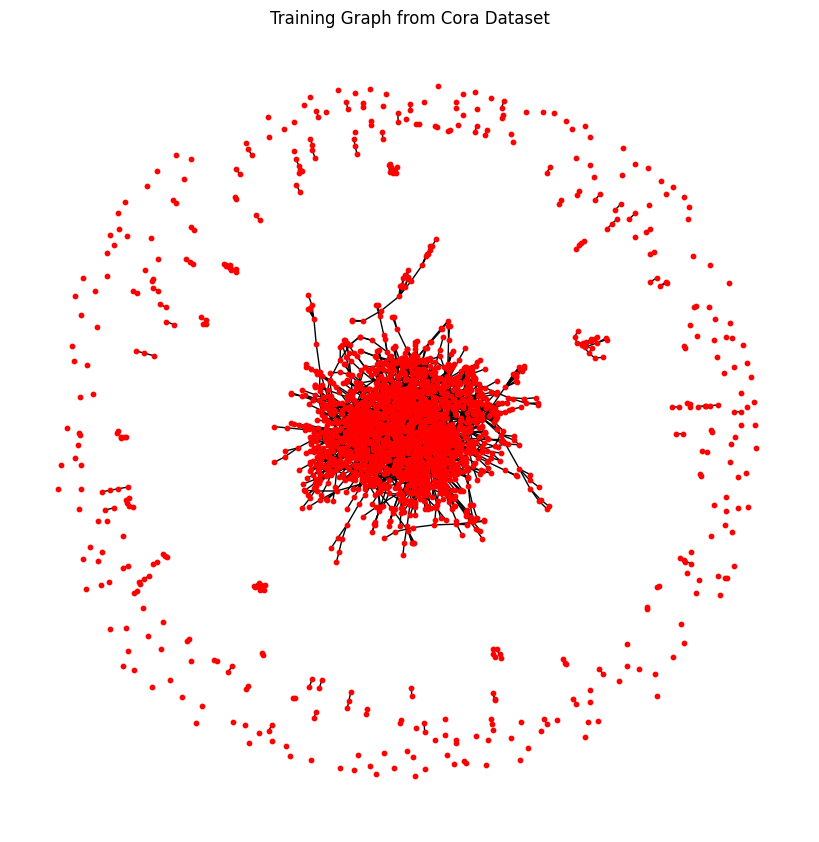

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG data object to a NetworkX graph
G = to_networkx(train_data, to_undirected=True)

# Plot using spring layout (force-directed)
plt.figure(figsize=(8, 8))
nx.draw(G,
        node_size=10,
        node_color='red',
        edge_color='black',
        with_labels=False,
        pos=nx.spring_layout(G, seed=1))  # Seed for reproducibility
plt.title("Training Graph from Cora Dataset")
plt.show()


In [ ]:
(train_data.edge_index[0] <= train_data.edge_index[1]).sum()

tensor(3696)

In [ ]:
edge_index = train_data.edge_index
mask = edge_index[0] <= edge_index[1]
undirected_edges = edge_index[:, mask]  # Only (i, j) with i <= j
print(undirected_edges.shape[1])  # Should print 3696


3696


Plot filter clean data

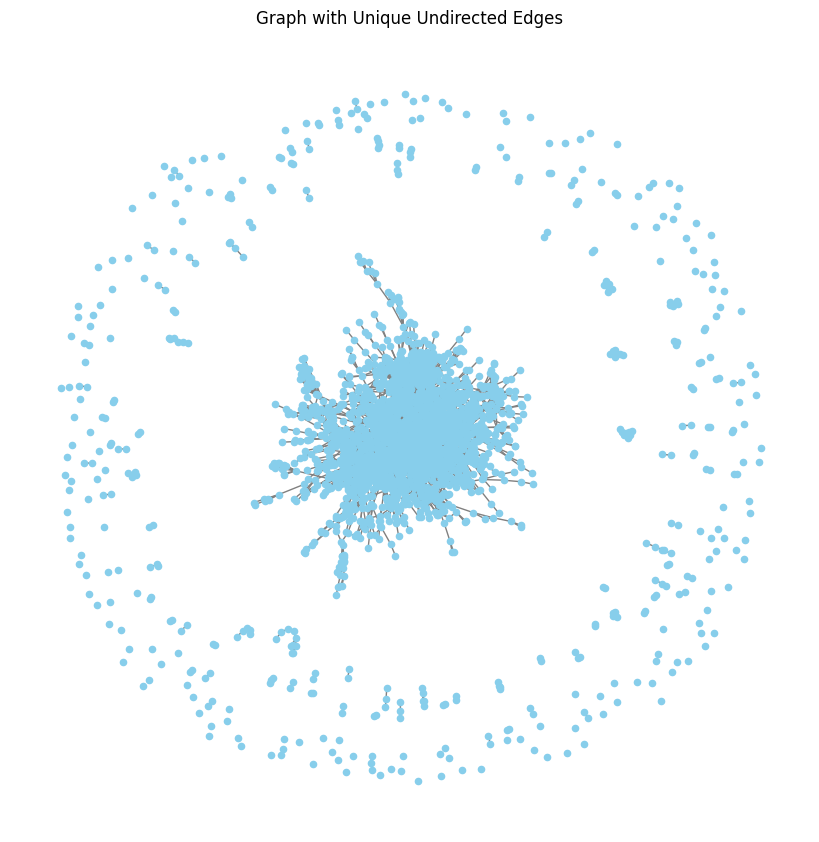

In [ ]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Filter unique undirected edges: i <= j
edge_index = train_data.edge_index
mask = edge_index[0] <= edge_index[1]
unique_edges = edge_index[:, mask]

# Create new Data object with filtered edges
from torch_geometric.data import Data
data_clean = Data(x=train_data.x, edge_index=unique_edges)

# Convert to NetworkX and plot
G = to_networkx(data_clean, to_undirected=True)
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=20, node_color='skyblue', edge_color='gray', with_labels=False)
plt.title("Graph with Unique Undirected Edges")
plt.show()


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

Model Training

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6930, Val: 0.6639, Test: 0.7084
Epoch: 002, Loss: 0.6826, Val: 0.6605, Test: 0.6989
Epoch: 003, Loss: 0.7089, Val: 0.6684, Test: 0.7074
Epoch: 004, Loss: 0.6782, Val: 0.6886, Test: 0.7283
Epoch: 005, Loss: 0.6850, Val: 0.7097, Test: 0.7466
Epoch: 006, Loss: 0.6880, Val: 0.7160, Test: 0.7515
Epoch: 007, Loss: 0.6884, Val: 0.7058, Test: 0.7429
Epoch: 008, Loss: 0.6871, Val: 0.6933, Test: 0.7304
Epoch: 009, Loss: 0.6835, Val: 0.6839, Test: 0.7194
Epoch: 010, Loss: 0.6778, Val: 0.6782, Test: 0.7112
Epoch: 011, Loss: 0.6732, Val: 0.6769, Test: 0.7059
Epoch: 012, Loss: 0.6747, Val: 0.6822, Test: 0.7058
Epoch: 013, Loss: 0.6675, Val: 0.6960, Test: 0.7146
Epoch: 014, Loss: 0.6594, Val: 0.7186, Test: 0.7341
Epoch: 015, Loss: 0.6540, Val: 0.7313, Test: 0.7470
Epoch: 016, Loss: 0.6482, Val: 0.7305, Test: 0.7445
Epoch: 017, Loss: 0.6385, Val: 0.7288, Test: 0.7418
Epoch: 018, Loss: 0.6314, Val: 0.7433, Test: 0.7631
Epoch: 019, Loss: 0.6159, Val: 0.7569, Test: 0.7872
Epoch: 020, 

In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

In [ ]:
final_edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    2,    4,  ..., 2705, 2706, 2707]])

Code to Plot Source and Target Nodes

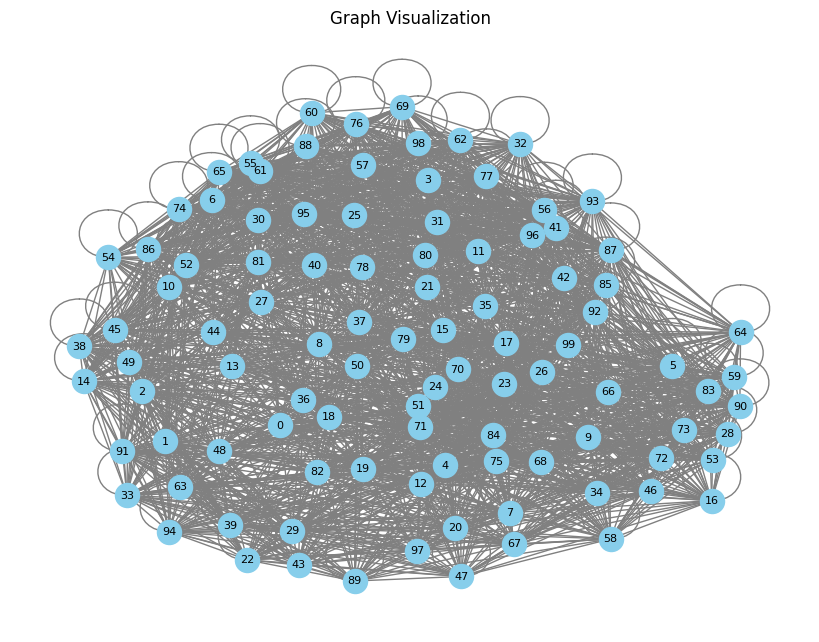

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# If your data is large, this will only plot part of it to avoid clutter.
# You can skip this if you want to plot the entire graph (but it may be dense).
max_nodes_to_plot = 100

# Create a graph using PyTorch Geometric utilities
# Let's assume you have a Data object to go with `final_edge_index`
from torch_geometric.data import Data

# Create dummy node features (required for Data)
num_nodes = final_edge_index.max().item() + 1
x = torch.ones((num_nodes, 1))  # 1 feature per node just as placeholder

# Create PyG data object
data = Data(x=x, edge_index=final_edge_index)

# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Optionally limit the number of nodes for clarity
if G.number_of_nodes() > max_nodes_to_plot:
    G = G.subgraph(list(G.nodes)[:max_nodes_to_plot])

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=300, font_size=8)
plt.title("Graph Visualization")
plt.show()


Code to Plot Source

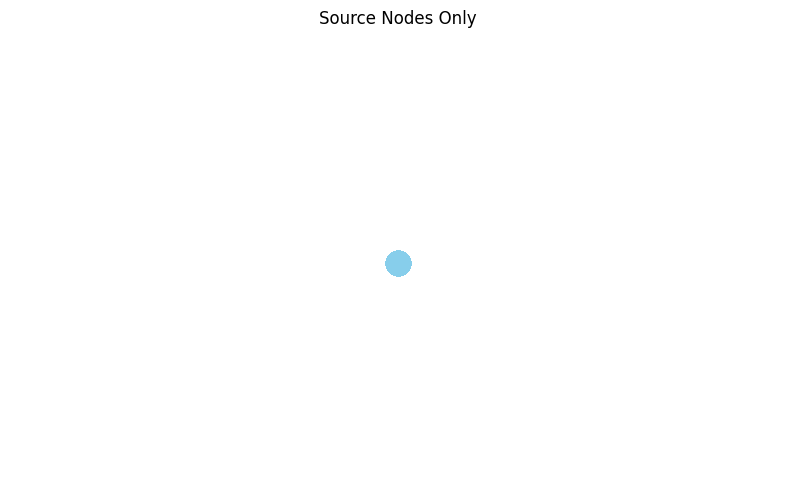

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Extract source nodes from final_edge_index
source_nodes = final_edge_index[0].tolist()

# Create a graph with source nodes only (no edges)
G = nx.Graph()
G.add_nodes_from(source_nodes)

# Optionally, reduce number of nodes to plot for clarity
max_nodes_to_plot = 100
nodes_to_plot = source_nodes[:max_nodes_to_plot]

# Plot the graph
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), nodelist=nodes_to_plot, node_color='skyblue', node_size=300)
nx.draw_networkx_labels(G, pos=nx.spring_layout(G), labels={n: str(n) for n in nodes_to_plot}, font_size=8)
plt.title("Source Nodes Only")
plt.axis('off')
plt.show()


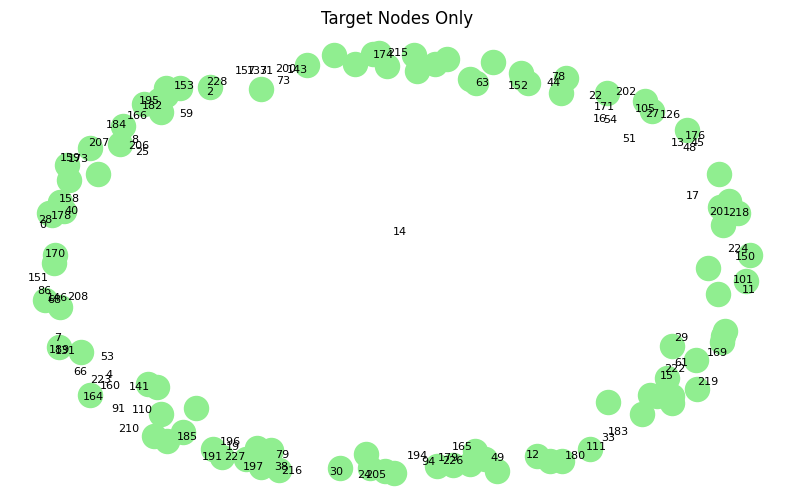

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Extract target nodes from final_edge_index
target_nodes = final_edge_index[1].tolist()

# Create a graph with target nodes only (no edges)
G = nx.Graph()
G.add_nodes_from(target_nodes)

# Optionally, reduce number of nodes to plot for clarity
max_nodes_to_plot = 100
nodes_to_plot = target_nodes[:max_nodes_to_plot]

# Plot the graph
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), nodelist=nodes_to_plot, node_color='lightgreen', node_size=300)
nx.draw_networkx_labels(G, pos=nx.spring_layout(G), labels={n: str(n) for n in nodes_to_plot}, font_size=8)
plt.title("Target Nodes Only")
plt.axis('off')
plt.show()


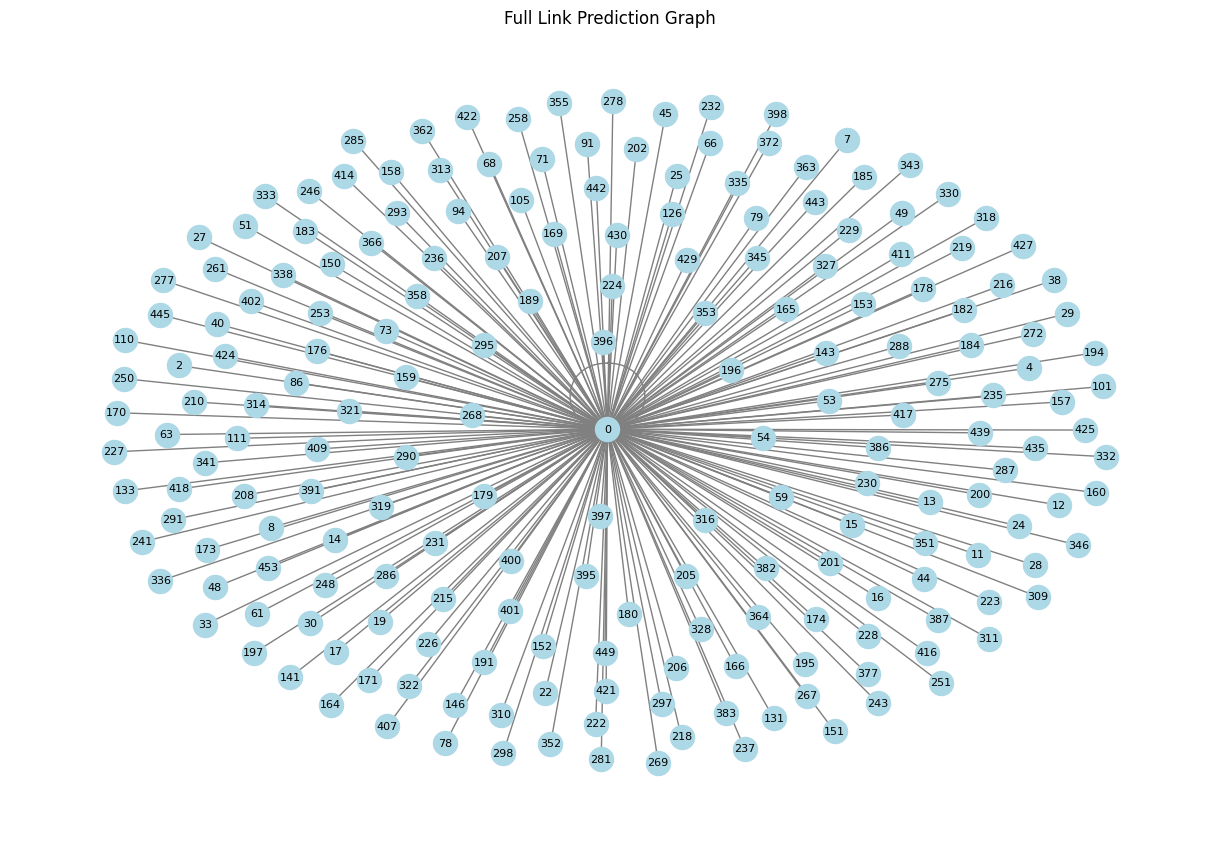

In [ ]:
# Full graph with edges from final_edge_index
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
edges = list(zip(final_edge_index[0].tolist(), final_edge_index[1].tolist()))
G.add_edges_from(edges)

# Optional: reduce number of edges for visualization clarity
max_edges = 200
G = G.edge_subgraph(edges[:max_edges])

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=8)
plt.title("Full Link Prediction Graph")
plt.show()


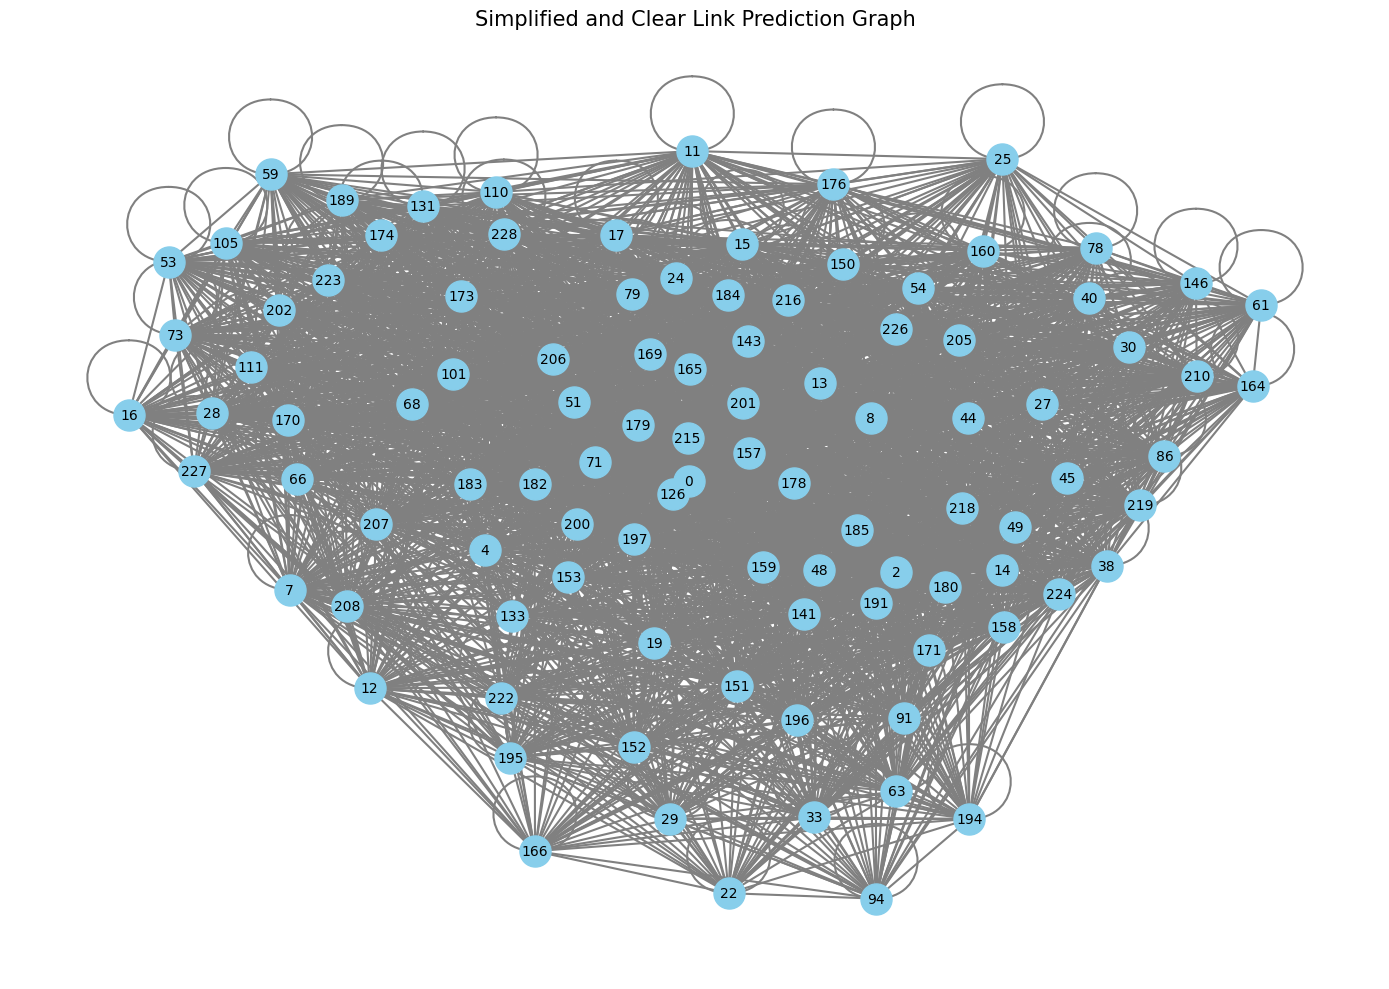

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.Graph()
edges = list(zip(final_edge_index[0].tolist(), final_edge_index[1].tolist()))
G.add_edges_from(edges)

# Reduce complexity: keep only first 100 nodes and their edges
sub_nodes = list(set(final_edge_index[0][:100].tolist() + final_edge_index[1][:100].tolist()))
G_sub = G.subgraph(sub_nodes)

# Use a spring layout for better spacing
pos = nx.spring_layout(G_sub, seed=42)

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_sub, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G_sub, pos, edge_color='gray', width=1.5)
nx.draw_networkx_labels(G_sub, pos, font_size=10, font_color='black')

plt.title("Simplified and Clear Link Prediction Graph", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Ensure that model is in evaluation mode
model.eval()

# Step 1.1: Generate node embeddings using the test data
z = model.encode(test_data.x, test_data.edge_index)

# Step 1.2: Access positive and negative edges from the test split
# test_data contains pos_edge_index and neg_edge_index after RandomLinkSplit
# These are indices of positive and negative edges for the test set
pos_edge_index = test_data.edge_label_index[:, test_data.edge_label == 1]  # Positive edges
neg_edge_index = test_data.edge_label_index[:, test_data.edge_label == 0]  # Negative edges

# Step 1.3: Combine positive and negative edges to form edge_index
edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)

# Step 1.4: Perform link prediction (logits output)
link_logits = model.decode(z, edge_index)
link_probs = link_logits.sigmoid()

# Step 1.5: Generate true labels for the edges (1 for positive edges and 0 for negative edges)
link_labels = torch.cat([
    torch.ones(pos_edge_index.size(1)),  # Positive edges (1)
    torch.zeros(neg_edge_index.size(1))   # Negative edges (0)
])

# Step 1.6: Convert the link prediction probabilities into binary predictions (using a threshold of 0.5)
predictions = (link_probs > 0.5).float()

# Now we have link_labels (true labels) and predictions (predicted labels)


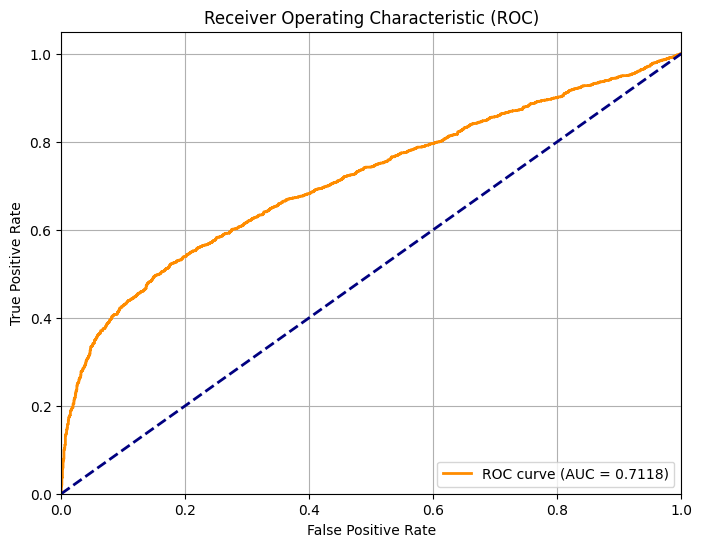

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling

# Make sure the model is in evaluation mode
model.eval()

# Step 1: Encode node embeddings
z = model.encode(test_data.x, test_data.edge_index)

# Step 2: Generate negative samples (equal to number of positive edges in test set)
neg_edge_index = negative_sampling(
    edge_index=test_data.edge_index,
    num_nodes=test_data.num_nodes,
    num_neg_samples=test_data.edge_label_index.size(1)  # Use same number as positive edges
)

# Step 3: Concatenate positive and negative edges
edge_index = torch.cat([test_data.edge_label_index, neg_edge_index], dim=1)

# Step 4: Predict link probabilities
link_logits = model.decode(z, edge_index)
link_probs = link_logits.sigmoid()

# Step 5: Create true labels: 1s for positive edges, 0s for negative
link_labels = torch.cat([
    torch.ones(test_data.edge_label_index.size(1)),
    torch.zeros(neg_edge_index.size(1))
])

# Step 6: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(link_labels.cpu().numpy(), link_probs.detach().cpu().numpy())
roc_auc = auc(fpr, tpr)

# Step 7: Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert probabilities to binary predictions using a threshold (0.5)
predictions = (link_probs > 0.5).float()

# Accuracy
accuracy = accuracy_score(link_labels.cpu(), predictions.cpu())
precision = precision_score(link_labels.cpu(), predictions.cpu())
recall = recall_score(link_labels.cpu(), predictions.cpu())
f1 = f1_score(link_labels.cpu(), predictions.cpu())

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.6346
Precision: 0.6183
Recall   : 0.7033
F1 Score : 0.6581


In [ ]:
torch.save(model.state_dict(), "gnn_link_prediction_model.pt")
